In [46]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2
from pathlib import Path
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    auc,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# import gdown
# # Use the file ID from the shareable link
# file_id = "1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti"
# url = f"https://drive.google.com/uc?id={file_id}"
# output = "data.zip"

# gdown.download(url, output, quiet=False)
# !unzip -q ./data.zip -d data

In [3]:
# 1. Set the folder path
# --------------------------------------------------
train_REAL = "data/train/REAL"
train_FAKE = "data/train/FAKE"
test_REAL = "data/test/REAL"
test_FAKE = "data/test/FAKE"

In [4]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [5]:
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0
X_train_flat = X_train_normalized.reshape(100000, -1)
X_test_flat = X_test_normalized.reshape(20000, -1)

In [6]:
X_train_flat.shape

(100000, 3072)

In [7]:
TRAIN_SIZE = 10000
TEST_SIZE = 2000
X_train_reduced, _, y_train_reduced, _ = train_test_split(
    X_train_flat, y_train,
    train_size=TRAIN_SIZE,
    stratify=y_train,
    random_state=42
)

X_test_reduced, _, y_test_reduced, _ = train_test_split(
    X_test_flat, y_test,
    train_size=TEST_SIZE,
    stratify=y_test,
    random_state=42
)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)


In [9]:
%%time
# Fit PCA with maximum components (or reasonable subset)
pca_100 = PCA(n_components=100)  # Using 500 instead of 3072 for speed
pca_100.fit(X_train_scaled)

CPU times: user 11.6 s, sys: 120 ms, total: 11.7 s
Wall time: 1.83 s


PCA(n_components=100)

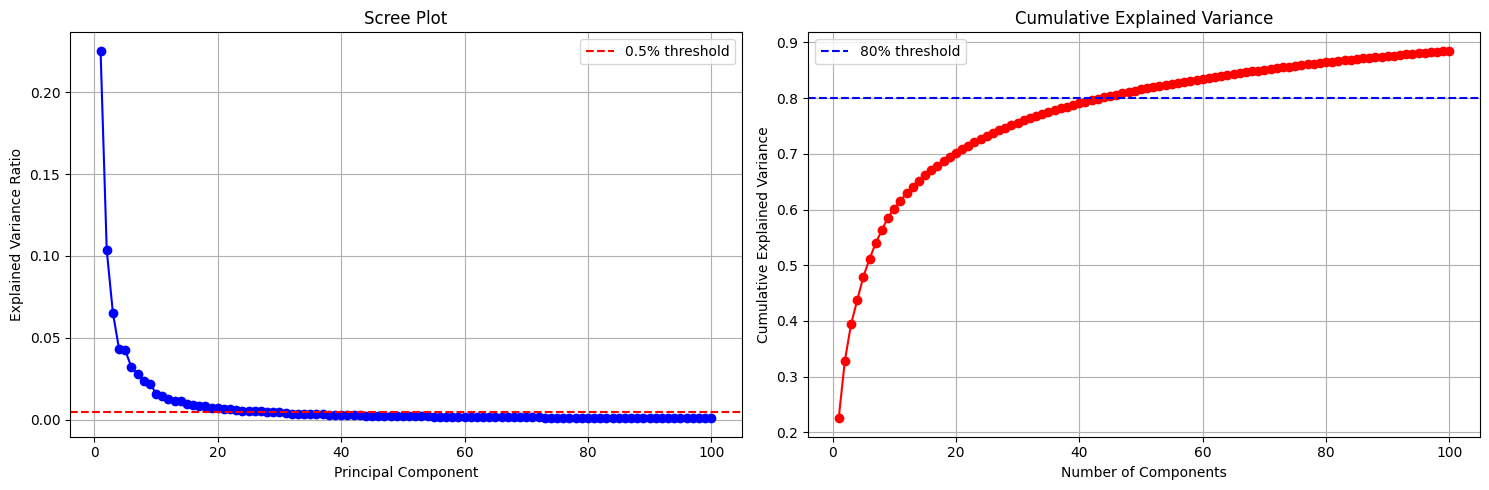

In [10]:
# Calculate cumulative explained variance
explained_variance = pca_100.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Scree plot (elbow method)
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].grid(True)
axes[0].axhline(y=0.005, color='r', linestyle='--', label='0.5% threshold')
axes[0].legend()

# Plot 2: Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].axhline(y=0.80, color='b', linestyle='--', label='80% threshold')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=40, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True))
])

param_grid = {
    'svm__C': [1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3,
                           scoring='accuracy', n_jobs=-1, verbose=2)

In [25]:
X_train_reduced.shape, X_test_reduced.shape

((10000, 3072), (2000, 3072))

In [26]:
%%time
print("\nTraining...")
grid_search.fit(X_train_reduced, y_train_reduced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")



Training...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'svm__C': 1.0, 'svm__gamma': 'scale'}
Best CV score: 0.767
CPU times: user 27.4 s, sys: 748 ms, total: 28.1 s
Wall time: 1min 56s


In [27]:
# Evaluate on train set
train_score = grid_search.score(X_train_reduced, y_train_reduced)
print(f"Train accuracy: {train_score:.3f}")

# Evaluate on test set
test_score = grid_search.score(X_test_reduced, y_test_reduced)
print(f"Test accuracy: {test_score:.3f}")

Train accuracy: 0.845
Test accuracy: 0.791


In [28]:
y_train_pred = grid_search.predict(X_train_reduced)
y_test_pred = grid_search.predict(X_test_reduced)

In [29]:
class_names = ['Fake', 'Real']

In [30]:
print(classification_report(y_train_reduced, y_train_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Fake     0.8458    0.8434    0.8446      5000
        Real     0.8438    0.8462    0.8450      5000

    accuracy                         0.8448     10000
   macro avg     0.8448    0.8448    0.8448     10000
weighted avg     0.8448    0.8448    0.8448     10000



In [31]:
print(classification_report(y_test_reduced, y_test_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Fake     0.7893    0.7940    0.7916      1000
        Real     0.7928    0.7880    0.7904      1000

    accuracy                         0.7910      2000
   macro avg     0.7910    0.7910    0.7910      2000
weighted avg     0.7910    0.7910    0.7910      2000



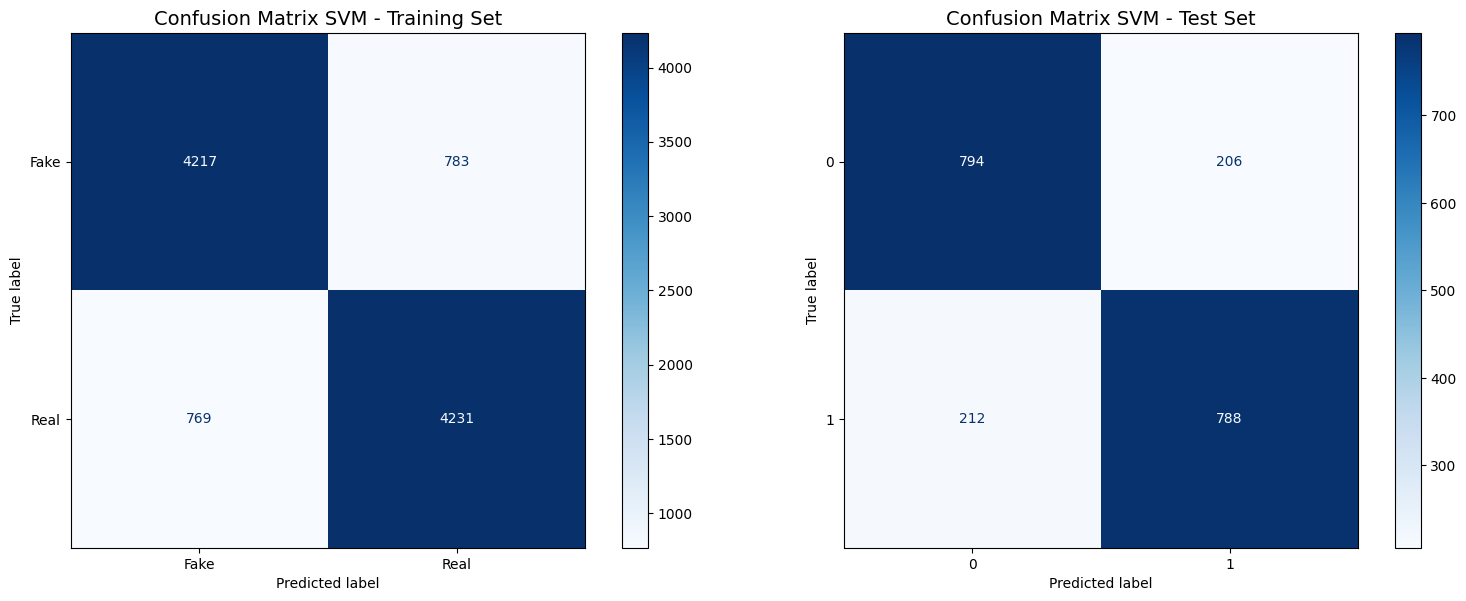

In [32]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train_reduced, y_train_pred)
cm_test = confusion_matrix(y_test_reduced, y_test_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix SVM - Training Set', fontsize=14)
axes[0].grid(False)

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix SVM - Test Set', fontsize=14)
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [39]:
y_test_prob = grid_search.predict_proba(X_test_reduced)[:, 1]

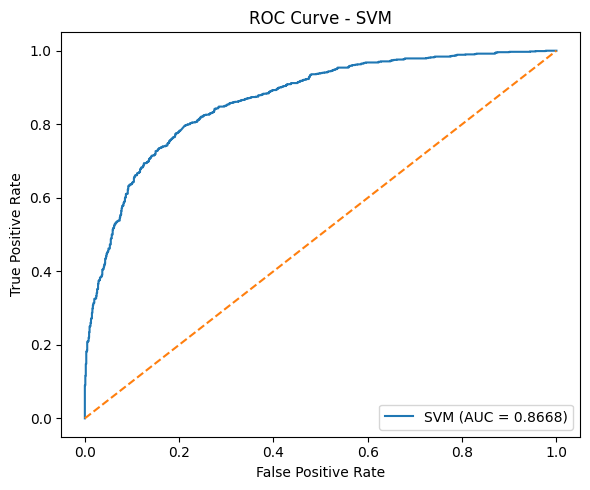

In [51]:
fpr_svm, tpr_svm, _ = roc_curve(y_test_reduced, y_test_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [37]:
import gdown
# Use the file ID from the shareable link
file_id = "16e63C7iUB8hqG8ZoZ657JrbkwaqQzp0G"
url = f"https://drive.google.com/uc?id={file_id}"
output = "sample.zip"

gdown.download(url, output, quiet=False)
!unzip -q ./sample.zip -d largeImageTest

Downloading...
From (original): https://drive.google.com/uc?id=16e63C7iUB8hqG8ZoZ657JrbkwaqQzp0G
From (redirected): https://drive.google.com/uc?id=16e63C7iUB8hqG8ZoZ657JrbkwaqQzp0G&confirm=t&uuid=3f1f7110-a7e4-4bd2-af40-4fd7b0fbfbcb
To: /content/sample.zip
100%|██████████| 115M/115M [00:01<00:00, 57.9MB/s]


In [42]:
test_large_REAL = "largeImageTest/label_0"
test_large_FAKE = "largeImageTest/label_1"

print("Loading large image test data...")
test_real_large_images, test_real_large_labels = load_images_from_folder(test_large_REAL, 1)
test_fake_large_images, test_fake_large_labels = load_images_from_folder(test_large_FAKE, 0)

X_large_test = np.concatenate((test_real_large_images, test_fake_large_images), axis=0)
y_large_test = np.concatenate((test_real_large_labels, test_fake_large_labels), axis=0)

train_indices = np.arange(X_large_test.shape[0])
np.random.shuffle(train_indices)
X_large_test = X_large_test[train_indices]
y_large_test = y_large_test[train_indices]

print(f"Testing data shape: {X_large_test.shape}")

Loading large image test data...
Testing data shape: (2000, 32, 32, 3)


In [55]:
X_large_test_normalized = X_large_test.astype('float32') / 255.0
X_large_test_flat = X_large_test_normalized.reshape(2000, -1)


y_large_test_pred = grid_search.predict(X_large_test_flat)
print(classification_report(y_large_test, y_large_test_pred, target_names=class_names))


              precision    recall  f1-score   support

        Fake       0.62      0.28      0.38      1000
        Real       0.53      0.83      0.65      1000

    accuracy                           0.55      2000
   macro avg       0.58      0.55      0.52      2000
weighted avg       0.58      0.55      0.52      2000

